# October ??th, 2021

**Motivation**: ?? <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(1, 4, (13., 3), gridspec_kw={'width_ratios': [1.8, 1, 1, 1.8]})

    x2plt = proj_h['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()
    
    
def get_h(pi_arr, approach='pi_animals'):
    if approach == 'pi_animals':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(pi, 2), 1)
        h = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])
        h = bn.nanmean(h, 0)
        hr = sp_stats.rankdata(h)
    elif approach == 'avg_pi_first':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(bn.nanmean(pi, 2), 1), 0)
        h = sp_stats.entropy(pi, axis=0) / np.log(len(pi))
        hr = sp_stats.rankdata(h)
    elif approach == 'no_pi_avg':
        h_arr = sp_stats.entropy(pi_arr, axis=-2) / np.log(pi_arr.shape[-2])
        h = bn.nanmean(h_arr, -3)
        h = bn.nanmean(bn.nanmean(bn.nanmean(h, 2), 1), 0)
    hr = sp_stats.rankdata(h)
    proj_h = gr.project_vec(h)
    proj_hr = gr.project_vec(hr)
    return h, hr, proj_h, proj_hr

In [3]:
%%time

mice = Mice((192, 4))

CPU times: user 207 ms, sys: 685 ms, total: 892 ms
Wall time: 892 ms


In [4]:
mice.setup_func_data()

In [5]:
props = {
    'mice': mice,
    'num_k': 6,
    'perc': 'p10-sample',
    'metric': 'spearman',  # 'pearson'
    'match_metric': 'euclidean',
    'match_using': 'gam',
    'prepare_data': False,
    'verbose': False,
    'task': 'rest',
}

In [6]:
gr = Group(mode='bold-lite', centroids_from='all', **props)
group_bold = gr.fit_group(skip_align=False)
pi_bold = bn.nanmean(bn.nanmean(group_bold['pi_run'], -3), 2)

gr = Group(mode='ca2', centroids_from='all', **props)
group_ca = gr.fit_group(skip_align=False)
pi_ca = bn.nanmean(bn.nanmean(group_ca['pi_run'], -3), 2)

pi_ca.shape, pi_bold.shape

Warning, nan in global order

Warning, nan in global order

((10, 3, 6, 302), (10, 3, 6, 302))

In [7]:
pi_ca_avg = bn.nanmean(bn.nanmean(pi_ca, 1), 0)
pi_bold_avg = bn.nanmean(bn.nanmean(pi_bold, 1), 0)

In [8]:
_disj = gr.get_disjoint_community(pi_ca_avg, to_vec=True)
_pi_ca = np.concatenate([pi_ca_avg, np.expand_dims(_disj, 0)])
proj_ca = gr.project_vec(_pi_ca)

_disj = gr.get_disjoint_community(pi_bold_avg, to_vec=True)
_pi_bold = np.concatenate([pi_bold_avg, np.expand_dims(_disj, 0)])
proj_bold = gr.project_vec(_pi_bold)

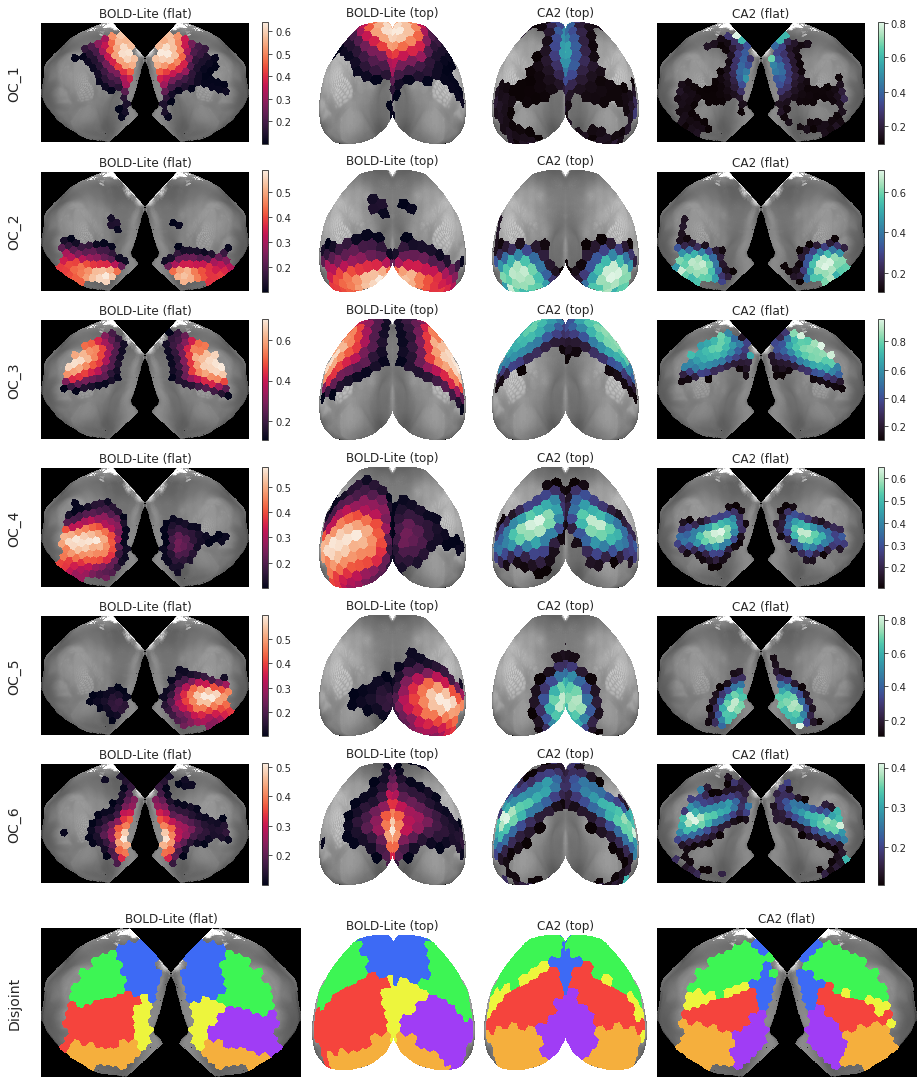

In [9]:
_ = gr.show(
    proj_1=proj_bold, proj_2=proj_ca,
    labels=('BOLD-Lite', 'CA2'),
    cmaps=('rocket', 'mako'),
    display=True,
)

In [10]:
nonan = np.where(np.isnan(pi_ca_avg * pi_bold_avg).sum(0) == 0)[0]

sim = dist2sim(sp_dist.cdist(
    pi_ca_avg[:, nonan],
    pi_bold_avg[:, nonan],
    metric='cosine'
))
mapping = find_best_match(sim)
mapping

{0: 0, 1: 1, 2: 2, 3: 3, 4: 5, 5: 4}

In [11]:
pi_bold = pi_bold[..., list(mapping.values()), :]
pi_bold_avg = bn.nanmean(bn.nanmean(pi_bold, 1), 0)

_disj = gr.get_disjoint_community(pi_bold_avg, to_vec=True)
_pi_bold = np.concatenate([pi_bold_avg, np.expand_dims(_disj, 0)])
proj_bold = gr.project_vec(_pi_bold)

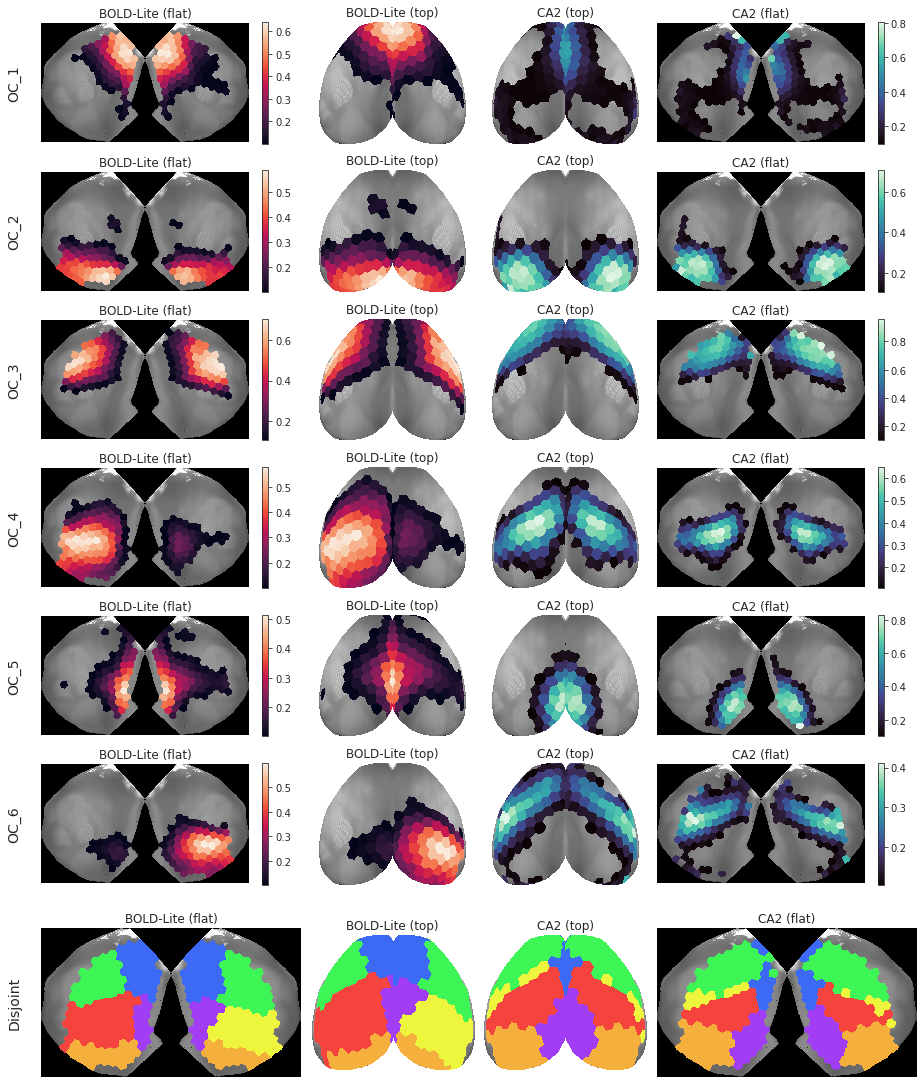

In [12]:
_ = gr.show(
    proj_1=proj_bold, proj_2=proj_ca,
    labels=('BOLD-Lite', 'CA2'),
    cmaps=('rocket', 'mako'),
    display=True,
)

In [13]:
fig, _ = gr.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', 'CA2'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"k{props.get('num_k')} / {props.get('perc')}"
sup = fig.suptitle(sup, fontsize=20, y=1.02)

In [14]:
fig.savefig(
    pjoin(tmp_dir, 'communities_svinet.pdf'),
    bbox_extra_artists=[sup],
    bbox_inches='tight',
)
fig.savefig(
    pjoin(tmp_dir, 'communities_svinet.png'),
    bbox_extra_artists=[sup],
    bbox_inches='tight', 
    dpi=200,
)

In [ ]:
for key, (sub, ses)

In [30]:
net_ca = Network(mice, mode='ca2', metric='pearson').load_network()
net_bold = Network(mice, mode='bold-lite', metric='pearson').load_network()

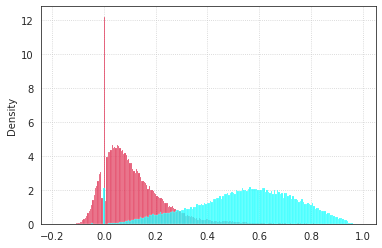

In [32]:
sns.histplot(net_bold.adj[np.isfinite(net_bold.adj)], bins=200, color='crimson', stat='density')
sns.histplot(net_ca.adj[np.isfinite(net_ca.adj)], bins=200, color='cyan', stat='density')
plt.grid()

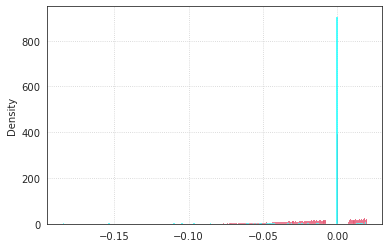

In [36]:
sns.histplot(net_bold.adj[net_bold.adj < 0.02], bins=200, color='crimson', stat='density')
sns.histplot(net_ca.adj[net_ca.adj < 0.02], bins=200, color='cyan', stat='density')
plt.grid()

In [13]:
combos = []
for a in itertools.combinations(mice.cfg.sub_ids, mice.cfg.num_subjects // 2):
    combos.append(list(a))
pairs = [(combos[i], combos[-i - 1]) for i in range(len(combos) // 2)]
assert all(set(x[0] + x[1]) == set(mice.cfg.sub_ids) for x in pairs)

pairs = [
    tuple((
        np.array([i - 1 for i in a]),
        np.array([j - 1 for j in b])
    )) for a, b in pairs
]
len(pairs)

126

In [14]:
dlist = []
for pair_i, (a, b) in tqdm(enumerate(pairs), total=len(pairs)):
    for mode, _pi in [('bold-lite', pi_bold), ('ca2', pi_ca)]:
        pi_a = bn.nanmean(_pi[a], 0)
        pi_b = bn.nanmean(_pi[b], 0)
        for i in range(mice.cfg.num_sessions):
            scores = pi_scores(pi_a[i], pi_b[i], 'cosine')
            dlist.append({
                'pair': [pair_i] * len(scores),
                'mode': [mode] * len(scores),
                'cond': ['across_animals'] * len(scores),
                'label': ['cosine'] * len(scores),
                'ses-1st': [i] * len(scores),
                'ses-2nd': [i] * len(scores),
                'oc_idx': scores.keys(),
                'node': [-1] * len(scores),
                'value': scores.values(),
            })
            
            scores = pi_scores(pi_a[i], pi_b[i], 'js')
            dlist.append({
                'pair': [pair_i] * len(scores),
                'mode': [mode] * len(scores),
                'cond': ['across_animals'] * len(scores),
                'label': ['js'] * len(scores),
                'ses-1st': [i] * len(scores),
                'ses-2nd': [i] * len(scores),
                'oc_idx': [-1] * len(scores),
                'node': scores.keys(),
                'value': scores.values(),
            })
            
            scores = pi_scores(pi_a[i], pi_b[i], 'hamming')
            dlist.append({
                'pair': [pair_i],
                'mode': [mode],
                'cond': ['across_animals'],
                'label': ['hamming'],
                'ses-1st': [i],
                'ses-2nd': [i],
                'oc_idx': [-1],
                'node': [-1],
                'value': [scores[-1]],
            })

        for i, j in itertools.combinations(range(mice.cfg.num_sessions), 2):
            scores_a = pi_scores(pi_a[i], pi_a[j], 'cosine')
            scores_b = pi_scores(pi_b[i], pi_b[j], 'cosine')
            scores = {
                k: (val_a + scores_b[k]) / 2
                for k, val_a in scores_a.items()
            }
            dlist.append({
                'pair': [pair_i] * len(scores),
                'mode': [mode] * len(scores),
                'cond': ['across_sessions'] * len(scores),
                'label': ['cosine'] * len(scores),
                'ses-1st': [i] * len(scores),
                'ses-2nd': [j] * len(scores),
                'oc_idx': scores.keys(),
                'node': [-1] * len(scores),
                'value': scores.values(),
            })

            scores_a = pi_scores(pi_a[i], pi_a[j], 'js')
            scores_b = pi_scores(pi_b[i], pi_b[j], 'js')
            scores = {
                k: (val_a + scores_b[k]) / 2
                for k, val_a in scores_a.items()
            }
            dlist.append({
                'pair': [pair_i] * len(scores),
                'mode': [mode] * len(scores),
                'cond': ['across_sessions'] * len(scores),
                'label': ['js'] * len(scores),
                'ses-1st': [i] * len(scores),
                'ses-2nd': [j] * len(scores),
                'oc_idx': [-1] * len(scores),
                'node': scores.keys(),
                'value': scores.values(),
            })
            
            scores_a = pi_scores(pi_a[i], pi_a[j], 'hamming')
            scores_b = pi_scores(pi_b[i], pi_b[j], 'hamming')
            scores = {
                k: (val_a + scores_b[k]) / 2
                for k, val_a in scores_a.items()
            }
            dlist.append({
                'pair': [pair_i],
                'mode': [mode],
                'cond': ['across_sessions'],
                'label': ['hamming'],
                'ses-1st': [i],
                'ses-2nd': [j],
                'oc_idx': [-1],
                'node': [-1],
                'value': [scores[-1]],
            })
            
df = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/126 [00:00<?, ?it/s]

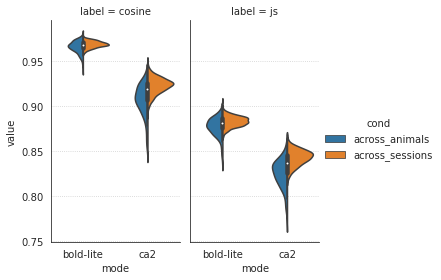

In [15]:
_df = df.loc[
    (df['node'] == -1) &
    (df['oc_idx'] == -1) &
    (df['label'] != 'hamming')
]

fg = sns.catplot(
    data=_df,
    x='mode',
    y='value',
    hue='cond',
    kind='violin',
    col='label',
    split=True,
    inner='box',
    aspect=0.6,
    height=4,
)
for ax in fg.axes.flat:
    ax.grid(axis='y')

In [16]:
fg.fig.savefig(pjoin(tmp_dir, 'reproducibility_spearman.pdf'), bbox_inches='tight')

In [18]:
pi_scores(pi_ca_avg, pi_bold_avg, 'cosine')[-1], pi_scores(pi_ca_avg, pi_bold_avg, 'js')[-1]

(0.7560248313839052, 0.6939133800432388)

In [20]:
js = pi_scores(pi_ca_avg, pi_bold_avg, 'js')
js = [
    js.get(node, np.nan)
    for node in gr.n2l
]
proj_js = gr.project_vec(np.reshape(js, (1, -1)))

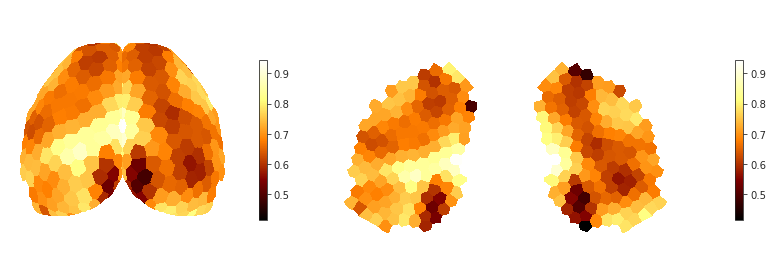

In [21]:
fig, axes = create_figure(1, 2, (13, 4), gridspec_kw={'width_ratios': [1, 1.2]})

x2plt = proj_js['parcel2d-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
im = axes[0].imshow(x2plt, cmap='afmhot')
plt.colorbar(im, ax=axes[0], shrink=.6)

x2plt = proj_js['parcel2d-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
im = axes[1].imshow(x2plt, cmap='afmhot')
plt.colorbar(im, ax=axes[1], shrink=.6)

remove_ticks(axes)

In [23]:
pi_scores(pi_ca_avg, pi_bold_avg, 'cosine')

{
    1: 0.856123331987014,
    2: 0.8314410165674823,
    3: 0.8693110871105838,
    4: 0.7817922924220554,
    5: 0.6997103387884321,
    6: 0.49777092142786383,
    -1: 0.7560248313839052
}

In [24]:
pi_scores(pi_ca_avg, pi_bold_avg, 'hamming')[-1]

0.5264900662251656

In [25]:
xxx = bn.nanmean(pi_ca, 0)
for i, j in itertools.combinations(range(3), 2):
    print(i, j, pi_scores(xxx[i], xxx[j], 'cosine')[-1])

0 1 0.9510215525920814

0 2 0.9383803392389823

1 2 0.9463093415608684

In [26]:
xxx = bn.nanmean(pi_bold, 0)
for i, j in itertools.combinations(range(3), 2):
    print(i, j, pi_scores(xxx[i], xxx[j], 'cosine')[-1])

0 1 0.9855533669296631

0 2 0.985010951931776

1 2 0.9827771692994012

## Different props

In [27]:
props = {
    'mice': mice,
    'num_k': 5,
    'perc': 'p15-sample',
    'metric': 'pearson',  # 'spearman'
    'match_metric': 'euclidean',
    'match_using': 'gam',
    'prepare_data': False,
    'verbose': False,
    'task': 'rest',
}

In [28]:
gr = Group(mode='bold-lite', centroids_from='all', **props)
group_bold = gr.fit_group(skip_align=False)
pi_bold = bn.nanmean(bn.nanmean(group_bold['pi_run'], -3), 2)

gr = Group(mode='ca2', centroids_from='all', **props)
group_ca = gr.fit_group(skip_align=False)
pi_ca = bn.nanmean(bn.nanmean(group_ca['pi_run'], -3), 2)

pi_ca.shape, pi_bold.shape

Warning, nan in global order

Warning, nan in global order

((10, 3, 5, 302), (10, 3, 5, 302))

In [29]:
pi_ca_avg = bn.nanmean(bn.nanmean(pi_ca, 1), 0)
pi_bold_avg = bn.nanmean(bn.nanmean(pi_bold, 1), 0)

In [30]:
_disj = gr.get_disjoint_community(pi_ca_avg, to_vec=True)
_pi_ca = np.concatenate([pi_ca_avg, np.expand_dims(_disj, 0)])
proj_ca = gr.project_vec(_pi_ca)

_disj = gr.get_disjoint_community(pi_bold_avg, to_vec=True)
_pi_bold = np.concatenate([pi_bold_avg, np.expand_dims(_disj, 0)])
proj_bold = gr.project_vec(_pi_bold)

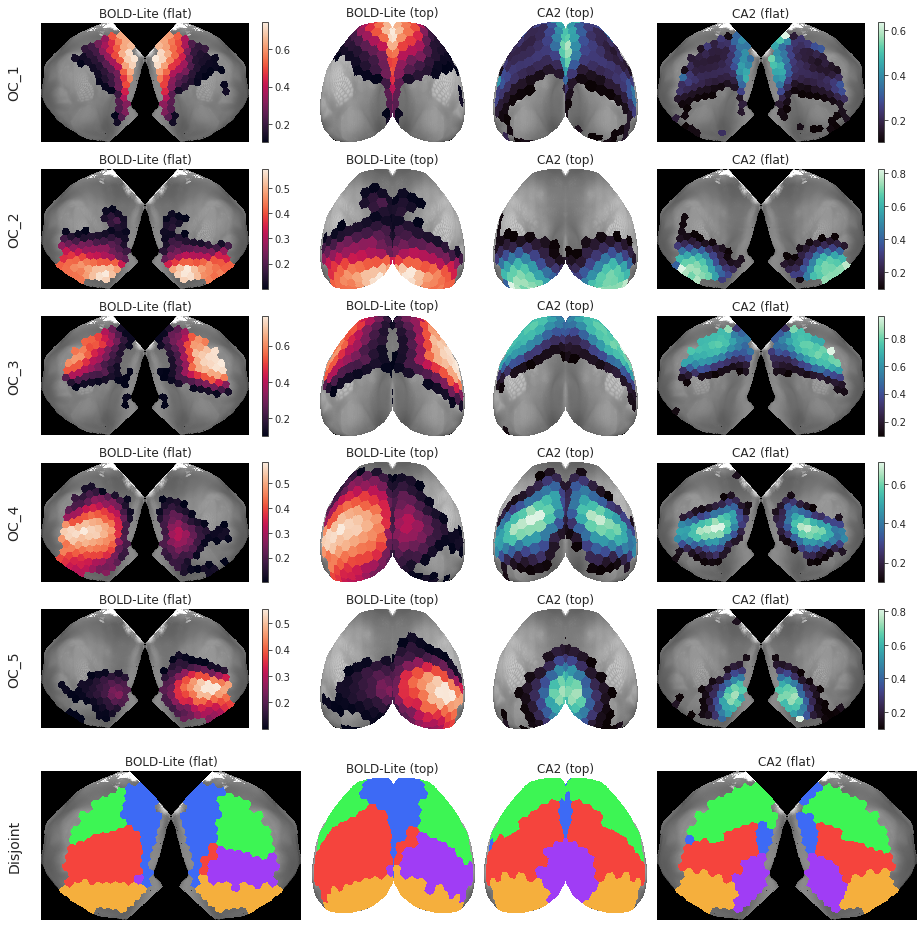

In [31]:
_ = gr.show(
    proj_1=proj_bold, proj_2=proj_ca,
    labels=('BOLD-Lite', 'CA2'),
    cmaps=('rocket', 'mako'),
    display=True,
)

In [32]:
nonan = np.where(np.isnan(pi_ca_avg * pi_bold_avg).sum(0) == 0)[0]

sim = dist2sim(sp_dist.cdist(
    pi_ca_avg[:, nonan],
    pi_bold_avg[:, nonan],
    metric='cosine'
))
mapping = find_best_match(sim)
mapping

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

In [33]:
pi_bold = pi_bold[..., list(mapping.values()), :]
pi_bold_avg = bn.nanmean(bn.nanmean(pi_bold, 1), 0)

_disj = gr.get_disjoint_community(pi_bold_avg, to_vec=True)
_pi_bold = np.concatenate([pi_bold_avg, np.expand_dims(_disj, 0)])
proj_bold = gr.project_vec(_pi_bold)

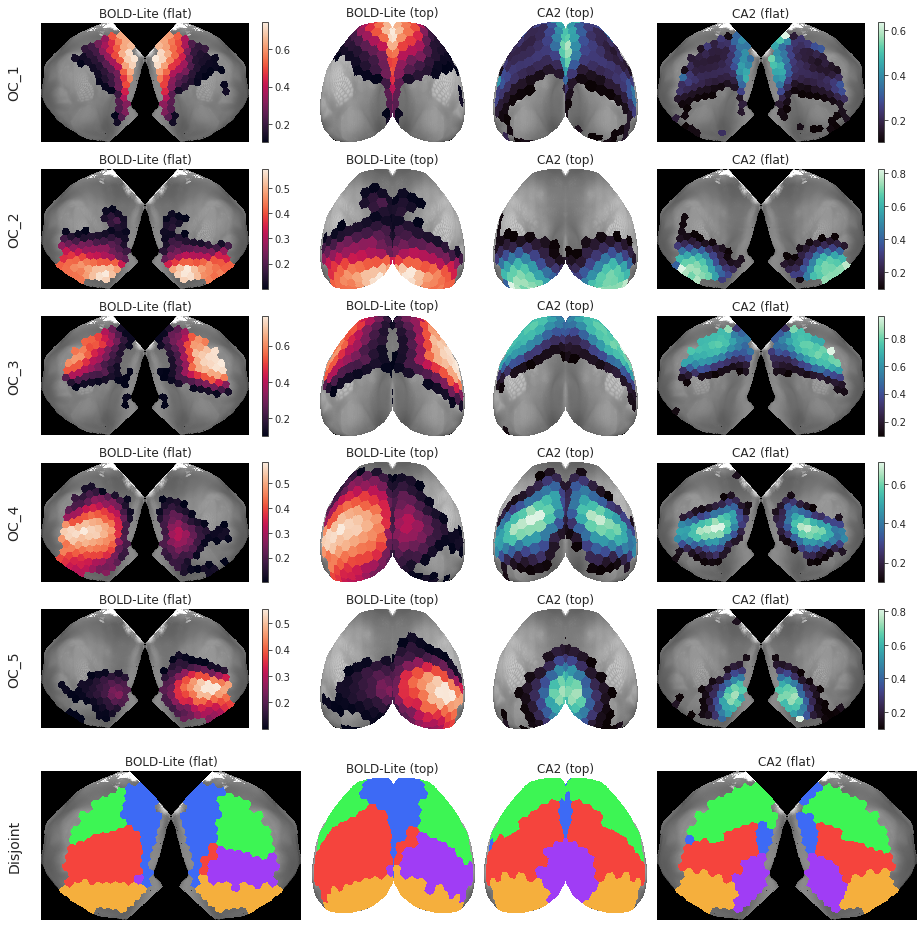

In [34]:
_ = gr.show(
    proj_1=proj_bold, proj_2=proj_ca,
    labels=('BOLD-Lite', 'CA2'),
    cmaps=('rocket', 'mako'),
    display=True,
)

In [35]:
combos = []
for a in itertools.combinations(mice.cfg.sub_ids, mice.cfg.num_subjects // 2):
    combos.append(list(a))
pairs = [(combos[i], combos[-i - 1]) for i in range(len(combos) // 2)]
assert all(set(x[0] + x[1]) == set(mice.cfg.sub_ids) for x in pairs)

pairs = [
    tuple((
        np.array([i - 1 for i in a]),
        np.array([j - 1 for j in b])
    )) for a, b in pairs
]
len(pairs)

126

In [36]:
dlist = []
for pair_i, (a, b) in tqdm(enumerate(pairs), total=len(pairs)):
    for mode, _pi in [('bold-lite', pi_bold), ('ca2', pi_ca)]:
        pi_a = bn.nanmean(_pi[a], 0)
        pi_b = bn.nanmean(_pi[b], 0)
        for i in range(mice.cfg.num_sessions):
            scores = pi_scores(pi_a[i], pi_b[i], 'cosine')
            dlist.append({
                'pair': [pair_i] * len(scores),
                'mode': [mode] * len(scores),
                'cond': ['across_animals'] * len(scores),
                'label': ['cosine'] * len(scores),
                'ses-1st': [i] * len(scores),
                'ses-2nd': [i] * len(scores),
                'oc_idx': scores.keys(),
                'node': [-1] * len(scores),
                'value': scores.values(),
            })
            
            scores = pi_scores(pi_a[i], pi_b[i], 'js')
            dlist.append({
                'pair': [pair_i] * len(scores),
                'mode': [mode] * len(scores),
                'cond': ['across_animals'] * len(scores),
                'label': ['js'] * len(scores),
                'ses-1st': [i] * len(scores),
                'ses-2nd': [i] * len(scores),
                'oc_idx': [-1] * len(scores),
                'node': scores.keys(),
                'value': scores.values(),
            })
            
            scores = pi_scores(pi_a[i], pi_b[i], 'hamming')
            dlist.append({
                'pair': [pair_i],
                'mode': [mode],
                'cond': ['across_animals'],
                'label': ['hamming'],
                'ses-1st': [i],
                'ses-2nd': [i],
                'oc_idx': [-1],
                'node': [-1],
                'value': [scores[-1]],
            })


        for i, j in itertools.combinations(range(mice.cfg.num_sessions), 2):
            scores_a = pi_scores(pi_a[i], pi_a[j], 'cosine')
            scores_b = pi_scores(pi_b[i], pi_b[j], 'cosine')
            scores = {
                k: (val_a + scores_b[k]) / 2
                for k, val_a in scores_a.items()
            }
            dlist.append({
                'pair': [pair_i] * len(scores),
                'mode': [mode] * len(scores),
                'cond': ['across_sessions'] * len(scores),
                'label': ['cosine'] * len(scores),
                'ses-1st': [i] * len(scores),
                'ses-2nd': [j] * len(scores),
                'oc_idx': scores.keys(),
                'node': [-1] * len(scores),
                'value': scores.values(),
            })

            scores_a = pi_scores(pi_a[i], pi_a[j], 'js')
            scores_b = pi_scores(pi_b[i], pi_b[j], 'js')
            scores = {
                k: (val_a + scores_b[k]) / 2
                for k, val_a in scores_a.items()
            }
            dlist.append({
                'pair': [pair_i] * len(scores),
                'mode': [mode] * len(scores),
                'cond': ['across_sessions'] * len(scores),
                'label': ['js'] * len(scores),
                'ses-1st': [i] * len(scores),
                'ses-2nd': [j] * len(scores),
                'oc_idx': [-1] * len(scores),
                'node': scores.keys(),
                'value': scores.values(),
            })
            
            scores_a = pi_scores(pi_a[i], pi_a[j], 'hamming')
            scores_b = pi_scores(pi_b[i], pi_b[j], 'hamming')
            scores = {
                k: (val_a + scores_b[k]) / 2
                for k, val_a in scores_a.items()
            }
            dlist.append({
                'pair': [pair_i],
                'mode': [mode],
                'cond': ['across_sessions'],
                'label': ['hamming'],
                'ses-1st': [i],
                'ses-2nd': [j],
                'oc_idx': [-1],
                'node': [-1],
                'value': [scores[-1]],
            })
            
df = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/126 [00:00<?, ?it/s]

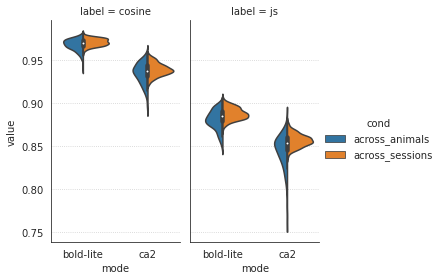

In [37]:
_df = df.loc[
    (df['node'] == -1) &
    (df['oc_idx'] == -1) &
    (df['label'] != 'hamming')
]

fg = sns.catplot(
    data=_df,
    x='mode',
    y='value',
    hue='cond',
    kind='violin',
    col='label',
    split=True,
    inner='box',
    aspect=0.6,
    height=4,
)
for ax in fg.axes.flat:
    ax.grid(axis='y')

In [38]:
fg.fig.savefig(pjoin(tmp_dir, 'reproducibility_pearson_p15.pdf'), bbox_inches='tight')

In [39]:
pi_scores(pi_ca_avg, pi_bold_avg, 'cosine')[-1], pi_scores(pi_ca_avg, pi_bold_avg, 'js')[-1]

(0.8413394075975965, 0.7592757791387283)

In [40]:
js = pi_scores(pi_ca_avg, pi_bold_avg, 'js')
js = [
    js.get(node, np.nan)
    for node in gr.n2l
]
proj_js = gr.project_vec(np.reshape(js, (1, -1)))

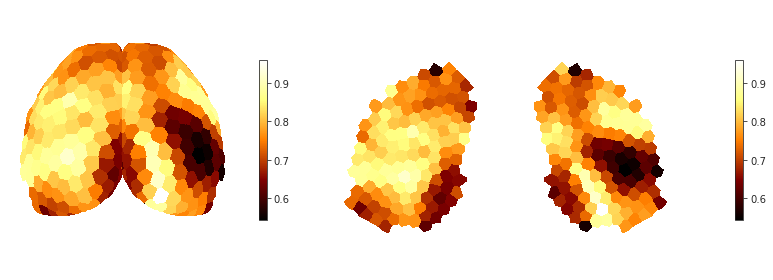

In [41]:
fig, axes = create_figure(1, 2, (13, 4), gridspec_kw={'width_ratios': [1, 1.2]})

x2plt = proj_js['parcel2d-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
im = axes[0].imshow(x2plt, cmap='afmhot')
plt.colorbar(im, ax=axes[0], shrink=.6)

x2plt = proj_js['parcel2d-flat'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
im = axes[1].imshow(x2plt, cmap='afmhot')
plt.colorbar(im, ax=axes[1], shrink=.6)

remove_ticks(axes)

In [43]:
pi_scores(pi_ca_avg, pi_bold_avg, 'cosine')

{
    1: 0.9151964494281378,
    2: 0.8911215394410603,
    3: 0.9011785846448506,
    4: 0.8271615692310508,
    5: 0.672038895242883,
    -1: 0.8413394075975965
}

In [44]:
pi_scores(pi_ca_avg, pi_bold_avg, 'hamming')[-1]

0.45364238410596025

In [45]:
xxx = bn.nanmean(pi_ca, 0)
for i, j in itertools.combinations(range(3), 2):
    print(i, j, pi_scores(xxx[i], xxx[j], 'cosine')[-1])

0 1 0.9502809575371008

0 2 0.9487283743367346

1 2 0.959451435664089

In [46]:
xxx = bn.nanmean(pi_bold, 0)
for i, j in itertools.combinations(range(3), 2):
    print(i, j, pi_scores(xxx[i], xxx[j], 'cosine')[-1])

0 1 0.9798399310766787

0 2 0.9866567520441138

1 2 0.9892293386573858